<a href="https://colab.research.google.com/github/Sujith1208/Assignment-for-NLP-Project/blob/main/Associated_Brand_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I have divided the problem statement into two parts : 1) Finding the emotion of the tweet 2) Finding the Brand which the tweet is directed to

Here we deal with the second part, Finding the Brand associated with the tweet.

Firstly, I have imported the dataset from my drive into the colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Read the dataset and printed out the dataset

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords

# Load the dataset
df_train = pd.read_excel(r'/content/drive/MyDrive/NLP Engineer Assignment Dataset (1) .xlsx', sheet_name='Train')
df_test = pd.read_excel(r'/content/drive/MyDrive/NLP Engineer Assignment Dataset (1) .xlsx', sheet_name='Test')
print(df_train.head())
print(df_test.head())



                                          tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1  @jessedee Know about @fludapp ? Awesome iPad/i...   
2  @swonderlin Can not wait for #iPad 2 also. The...   
3  @sxsw I hope this year's festival isn't as cra...   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...   

  emotion_in_tweet_is_directed_at  \
0                          iPhone   
1              iPad or iPhone App   
2                            iPad   
3              iPad or iPhone App   
4                          Google   

  is_there_an_emotion_directed_at_a_brand_or_product  
0                                   Negative emotion  
1                                   Positive emotion  
2                                   Positive emotion  
3                                   Negative emotion  
4                                   Positive emotion  
                                               Tweet
0  Hand-Held ���Hobo�۪: Drafthouse launches ���Ho...
1  A

In [ ]:
df_train.info()
df_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8589 entries, 0 to 8588
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8588 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8589 non-null   object
dtypes: object(3)
memory usage: 201.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   504 non-null    object
dtypes: object(1)
memory usage: 4.1+ KB


In [ ]:
print(df_train.isnull().sum())


tweet_text                                               1
emotion_in_tweet_is_directed_at                       5298
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64


In [ ]:
# Remove rows with null values in important columns
df_train = df_train.dropna(subset=['tweet_text', 'emotion_in_tweet_is_directed_at', 'is_there_an_emotion_directed_at_a_brand_or_product'])

In [ ]:
# Checking for null values again after removal
print("Null values after removal:")
print(df_train.isnull().sum())

Null values after removal:
tweet_text                                            0
emotion_in_tweet_is_directed_at                       0
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64


Cleaned the text by deleting all the stopwords in the dataset

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to clean text
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# Clean the tweets
df_train['cleaned_text'] = df_train['tweet_text'].apply(lambda x: clean_text(str(x)))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Performed EDA on the training dataset and plot all the findings

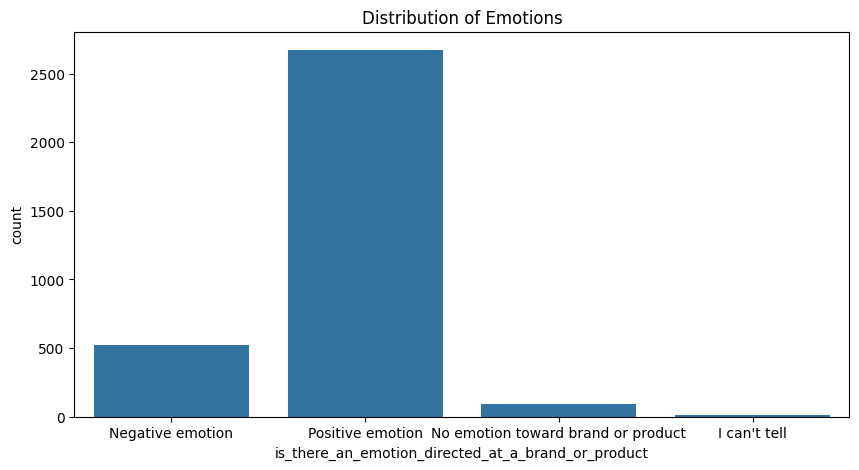

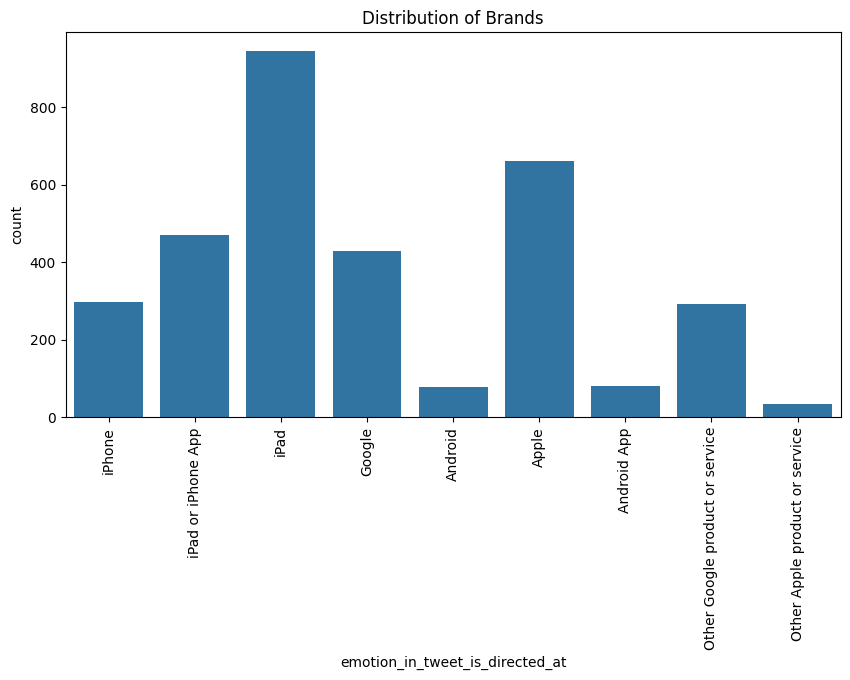

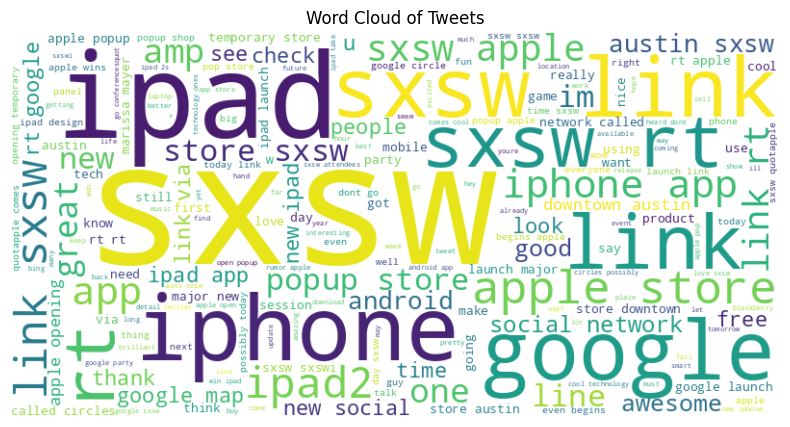

In [ ]:
# EDA: Distribution of emotions and brands
emotion_distribution = df_train['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()
brand_distribution = df_train['emotion_in_tweet_is_directed_at'].value_counts()

# Plot emotion distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=df_train, x='is_there_an_emotion_directed_at_a_brand_or_product')
plt.title('Distribution of Emotions')
plt.show()

# Plot brand distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=df_train, x='emotion_in_tweet_is_directed_at')
plt.title('Distribution of Brands')
plt.xticks(rotation=90)
plt.show()

# WordCloud for visualizing common words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_train['cleaned_text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweets')
plt.show()

This is the crusial part of the problem, Imported transformers for model training and Used BERT for Sequence Classification. Used Trainer from the tronsformer library to further finetune the BERT transformer.

Used external API called wandb for Trainer , It asks for a API key for executing , which can be found at there site.

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import torch

# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_train['cleaned_text'],
    df_train[['emotion_in_tweet_is_directed_at', 'is_there_an_emotion_directed_at_a_brand_or_product']],
    test_size=0.2,
    random_state=42
)

# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the text
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=128)

# Custom Dataset class
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        unique_labels = set(labels)
        self.label_mapping = {label: i for i, label in enumerate(unique_labels)}

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        label = self.label_mapping.get(self.labels[idx])
        item['labels'] = torch.tensor(label, dtype=torch.long) # -1 for unknown labels
        return item

    def __len__(self):
        return len(self.labels)

# Prepare dataset
train_dataset = TweetDataset(train_encodings, train_labels['emotion_in_tweet_is_directed_at'].tolist())
val_dataset = TweetDataset(val_encodings, val_labels['emotion_in_tweet_is_directed_at'].tolist())

# Model setup
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(train_labels['emotion_in_tweet_is_directed_at'].unique()))

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir='./logs',
    evaluation_strategy="steps"
)

# Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Train the model
trainer.train()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss


TrainOutput(global_step=495, training_loss=0.5493087614425505, metrics={'train_runtime': 2146.9356, 'train_samples_per_second': 3.678, 'train_steps_per_second': 0.231, 'total_flos': 81726027546240.0, 'train_loss': 0.5493087614425505, 'epoch': 3.0})

Trained the model on the tarining set and Printed the output for the validation dataset

In [ ]:
# Predict on the validation set
# Convert input_ids and attention_mask to tensors
input_ids = torch.tensor(val_encodings['input_ids'])
attention_mask = torch.tensor(val_encodings['attention_mask'])

logits = model(input_ids, attention_mask).logits

# Calculate predicted labels
preds = torch.argmax(logits, dim=1)

# Convert predictions back to labels for better interpretation
predicted_labels = [list(train_dataset.label_mapping.keys())[i] for i in preds.tolist()]

# Display results
print("Predictions:", predicted_labels)


Predictions: ['Apple', 'iPad', 'iPad', 'iPad', 'Apple', 'iPad', 'iPad or iPhone App', 'Google', 'Apple', 'iPad', 'Apple', 'Apple', 'Apple', 'Google', 'Apple', 'iPad', 'Other Google product or service', 'Other Google product or service', 'Google', 'Apple', 'Apple', 'iPad', 'Other Google product or service', 'Apple', 'Apple', 'Apple', 'Google', 'iPad', 'iPad or iPhone App', 'Google', 'iPad', 'Google', 'Google', 'iPad', 'iPad or iPhone App', 'Google', 'Apple', 'Other Google product or service', 'iPad', 'Other Google product or service', 'iPad', 'Apple', 'iPad', 'Android App', 'Android App', 'Apple', 'Other Google product or service', 'Other Google product or service', 'iPad or iPhone App', 'Apple', 'iPad', 'Apple', 'Apple', 'Apple', 'Android App', 'Google', 'Google', 'iPad or iPhone App', 'iPad', 'Google', 'iPad', 'Google', 'Apple', 'Apple', 'iPad', 'iPad or iPhone App', 'iPad', 'Google', 'iPhone', 'Other Google product or service', 'iPad', 'Apple', 'Apple', 'iPad', 'iPad', 'iPad', 'Apple